<a href="https://colab.research.google.com/github/apmoore1/fiesta/blob/master/notebooks/TDSA_AllenNLP_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+git://github.com/apmoore1/fiesta.git@master#egg=fiesta-nlp
!pip install git+git://github.com/apmoore1/Bella-AllenNLP.git@FIESTA#egg=bella-allennlp
!pip install nltk
import nltk
nltk.download('perluniprops')

In [3]:
from collections import defaultdict
from itertools import product
import json
from typing import List, Tuple, Dict, Any, Callable, Optional
from pathlib import Path
import random
import tempfile

from allennlp.common.params import Params
from allennlp.training.trainer import Trainer, TrainerPieces
from allennlp.training.util import evaluate
import bella_allen_nlp
import bella
import fiesta
import requests
from matplotlib import pyplot as plt
import pandas as pd
import torch
import seaborn as sns

Using TensorFlow backend.


In [0]:
def download_model_configs(training_config_folder: Path
                           ) -> Tuple[List[str], List[Path]]:
  '''
  :param training_config_folder: Folder to store the downloaded model 
                                 config files
  :returns: A Tuple containing 2 lists:
            1. A list of the model names
            2. A list of File Paths to the model names associated model 
               config file.
  '''
  base_url = 'https://raw.githubusercontent.com/apmoore1/fiesta/master/'\
             'allennlp_training_configs/TDSA/'
  model_names = ['atae', 'atae_50', 'ian', 'ian_50', 'lstm', 'lstm_50', 
                 'tdlstm', 'tdlstm_50']
  extension = '.jsonnet'
  config_fps = []
  for model_name in model_names:
    config_file_name = model_name + extension
    config_url = base_url + config_file_name
    response = requests.get(config_url, stream=True)
    config_fp = Path(training_config_folder, config_file_name).resolve()
    with config_fp.open('wb+') as config_file:
      for chunk in response.iter_content(chunk_size=128):
        config_file.write(chunk)
    config_fps.append(config_fp)
  return model_names, config_fps

def split_data(data: List[Dict[str, Any]]) -> Tuple[List[Dict[str, Any]], 
                                                    List[Dict[str, Any]]]:
  '''
  Splits the data into Train and Test data splits.
  
  We could use a function like sklearn.model_selection.train_test_split
  but the way the TDSA data has been parsed means that samples that use the 
  same sentence but have a different Target should be in the same data split 
  else one data split could contain different targets but the same sentence 
  hence why we have used this random splitting method instead which assumes 
  that the data has been parsed in such a way that all targets with the same 
  sentence are next to each other in the list.
  
  :params data: A dataset
  :returns: A tuple of Train, and Test data in the same format 
            as the original input.
  '''
  # Hard code the test data size as 20% of the original data
  data_size = len(data)
  test_data_size = int(data_size * 0.2)
  
  start_index = random.randint(0, data_size)
  end_index = start_index + test_data_size
  if end_index > data_size:
    index_diff = end_index - data_size
    test_data = data[start_index:]
    test_data.extend(data[:index_diff])
    train_data = data[index_diff:start_index]
  else:
    test_data = data[start_index: end_index]
    train_data = data[end_index:]
    train_data.extend(data[:start_index])
  return train_data, test_data

def write_data_to_file(data: List[Dict[str, Any]], data_fp: Path) -> None:
  '''
  :params data: Data to write to file
  :params data_fp: File path to write the data to
  :returns: Nothing
  '''
  with data_fp.open('w+') as data_file:
    for index, sample in enumerate(data):
      # Don't need the epoch number and it is not JSON serlizable easily
      if 'epoch_number' in sample:
        del sample['epoch_number']
      sample = json.dumps(sample)
      if index != 0:
        sample = f'\n{sample}'
      data_file.write(sample)
      
def add_data_to_params(train_data: List[Dict[str, Any]], 
                       dev_data: List[Dict[str, Any]], 
                       test_data: List[Dict[str, Any]],
                       data_dir: Path,
                       params: Params) -> None:
  '''
  Saves the Train, development, and test data to files within the `data_dir`.
  These file paths are then add to the `params`.
  '''
  files_names = ['train.json', 'dev.json', 'test.json']
  datasets = [train_data, dev_data, test_data]
  params_key = ['train_data_path', 'validation_data_path', 'test_data_path']

  for file_name, data, param_key in zip(files_names, datasets, params_key):
    # Save data to file within the directory given
    file_path = Path(data_dir, file_name)
    write_data_to_file(data, file_path)
    # Add data path to the params
    params[param_key] = file_path

# How to use the FIESTA package with custom AllenNLP models

In this tutorial we will show how to use the [FIESTA package](https://apmoore1.github.io/fiesta/index.html) with real world Target Dependent Sentiment Analysis (TDSA) models that have been created in PyTorch using the [AllenNLP package](https://allennlp.org/). We hope to create more tutorials using just PyTorch, TensorFlow/Keras, SKLearn, and a mixture of all 4 soon. These are "custom" AllenNLP models as we are not using AllenNLP models or dataset readers from the AllenNLP library but we are using custom TDSA version that sub-class the AllenNLP version, these have come from the [Bella-AllenNLP](https://github.com/apmoore1/Bella-AllenNLP) github repository.

We are going to replicate the experiments that were done in the [FIESTA paper](https://arxiv.org/pdf/1906.12230.pdf) but unlike the tutorial on [Advantages of model selection]() here we are not using static results that have been created by running each model 500 times. We are going to run the models each time we need them as you would in the real world to demonstrate how to use the [FIESTA package](https://apmoore1.github.io/fiesta/index.html) in any of your projects.

This notebook is broken down into 3 sections:
1. Set up - How to setup your project to use the [FIESTA package](https://apmoore1.github.io/fiesta/index.html)
2. Running [Fixed Confidence methods](https://apmoore1.github.io/fiesta/api/fixed_confidence.html)
3. Running [Fixed Budget methods](https://apmoore1.github.io/fiesta/api/fixed_budget.html)
4. Conclusion

**NOTE** It is best to run these models on a GPU as they can take a while to process on a CPU. Therefore I would advise either setting the Google Colab to a GPU runtime (Go to runtime option at the top of this notebook and click `change runtime`). OR run this notebook locally on your own GPU machine. 

## Set Up
This is split into 4 main steps:
1. Getting the data
2. Splitting the data
3. Models

### Getting the data
As stated earlier the task we are performing is TDSA and we are going to evaluate our TDSA methods on the well known English [SemEval 2014 task 4 Restaurant domain](http://alt.qcri.org/semeval2014/task4/) data. Training [data](http://metashare.ilsp.gr:8080/repository/browse/semeval-2014-absa-train-data-v20-annotation-guidelines/683b709298b811e3a0e2842b2b6a04d7c7a19307f18a4940beef6a6143f937f0/) (named Restaurants_Train_v2.xml) and test [data](http://metashare.ilsp.gr:8080/repository/browse/semeval-2014-absa-test-data-gold-annotations/b98d11cec18211e38229842b2b6a04d77591d40acd7542b7af823a54fb03a155/) (named Restaurants_Test_Gold.xml) can be found at their respective links from which this data needs downloading from.

#### Using Google Colab NOT LOCALLY
If your using Google Colab not locally you need to upload the training and testing files. Please do so by running the next code box

#### Using Google Colab LOCALLY
Please ignore the next code box as you do not need to upload the training or test data to anywhere. **HOWEVER** in this tutorial we will assume that the files you have downloaded are in the current directory that this notebook is running from.

In [0]:
from google.colab import files
for i in range(2):
  temp_uploaded = files.upload()

Saving Restaurants_Train_v2.xml to Restaurants_Train_v2.xml


Saving Restaurants_Test_Gold.xml to Restaurants_Test_Gold.xml


No we have the training and test data at the following paths **`./Restaurants_Train_v2.xml`** and **`./Restaurants_Test_Gold.xml`** respectively, we need to parse them from XML format into a List of dictionaries. To do this we are going to use the [Bella](https://github.com/apmoore1/Bella) package:

In [0]:
# If you are running this locally and have saved the files in a different 
# location change the file path appropriately
train_fp = Path('./Restaurants_Train_v2.xml').resolve()
test_fp = Path('./Restaurants_Test_Gold.xml').resolve()

train_data = bella.parsers.semeval_14(train_fp).data_dict()
test_data = bella.parsers.semeval_14(test_fp).data_dict()


The point in the [FIESTA paper](https://arxiv.org/pdf/1906.12230.pdf) is that we should take **both** **random seeds** and **data splits** into account if we want to reliably choose the best model^^. Therefore we now need to combine the Train and Test data together. 

^^(The intital work on random seeds was done by [Reimers and Gurevych, 2017](https://www.aclweb.org/anthology/D17-1035) and taking *data splits* into account was shown necessairy concurrently by the [FIESTA paper](https://arxiv.org/pdf/1906.12230.pdf) and [Gorman and Bedrick, 2019](https://wellformedness.com/papers/gorman-bedrick-2019.pdf))






In [6]:
whole_dataset = train_data + test_data
print(f'Length of the combined datasets: {len(whole_dataset)}')
print(f'Type of the dataset: {type(whole_dataset)}')
print(f'Type of the instances within the List: {type(whole_dataset[0])}')

Length of the combined datasets: 4722
Type of the dataset: <class 'list'>
Type of the instances within the List: <class 'dict'>


### Splitting the data

We also need to create a **data splitting** function that will take in a dataset which is a:
```python
List[Dict[str, Any]]
```
Which in our case is the `whole_dataset` and returns two of them:
```
Tuple[List[Dict[str, Any]], List[Dict[str, Any]]]
```

Of which this would represent the Train and Test datasets respectively, of which each time we call this **data splitting** function it should return a **random** Train and Test dataset.

We have already created this **data splitting** function for you and it can be found at the top of this notebook called **split_data** of which it is hard coded to split that data into 80% Train and 20% Test. Example of how it works below:

In [7]:
train_1, test_1 = split_data(whole_dataset)
print(f'Length of train: {len(train_1)}\nLength of test: {len(test_1)}')
print(f"Train's first instance: {train_1[0]}")
print(f"Test's first instance: {test_1[0]}")
train_1, test_1 = split_data(whole_dataset)
print('\nSplit again\n')
print(f"Train's first instance: {train_1[0]}")
print(f"Test's first instance: {test_1[0]}")

Length of train: 3778
Length of test: 944
Train's first instance: {'spans': [(15, 22)], 'target': 'service', 'text': 'Great friendly service, Fast seating, Fast Delivery, Excellent sushi.', 'sentiment': 1, 'epoch_number': {-1}, 'sentence_id': 'Restaurants_Train_v21034', 'target_id': 'Restaurants_Train_v210340'}
Test's first instance: {'spans': [(9, 36)], 'target': 'argentine chorizo appetizer', 'text': 'The lone argentine chorizo appetizer at $8.95 was a heavy fennel flavored Italian sausage like the ones that sell for $2.99/lb at the store.', 'sentiment': -1, 'epoch_number': {-1}, 'sentence_id': 'Restaurants_Test_Gold35886114#1249751#0', 'target_id': 'Restaurants_Test_Gold35886114#1249751#00'}

Split again

Train's first instance: {'spans': [(0, 26)], 'target': 'Guacamole+shrimp appetizer', 'text': "Guacamole+shrimp appetizer was really great, we both had the filet, very good, didn't much like the frites that came with, but the filet was so good, neither of us cared.", 'sentiment': 1,

As we can see when we split the data it does indeed gives us different splits of the data.

### Models
The next part of this process that we need are the **8 TDSA models** that we are going to evaluate to replicate the [FIESTA paper](https://arxiv.org/pdf/1906.12230.pdf). This process is split into 2 when using [AllenNLP](https://allennlp.org/):
1. Getting the model configurations
2. Converting the model configurations into functions

#### Getting the model configurations
Model configurations in essence describe the model that will be created which includes the model architecture, the way to process the data, and how to train the model (for more details on this read this section on [configuration files from AllenNLP](https://github.com/allenai/allennlp/blob/master/tutorials/tagger/README.md#using-config-files) or read all of the [tutorials from AllenNLP](https://github.com/allenai/allennlp/tree/master/tutorials) as they are all really good!)

The 8 models and their configuration files: 1. [TDLSTM 300](https://github.com/apmoore1/fiesta/blob/master/allennlp_training_configs/TDSA/tdlstm.jsonnet), 2. [TDLSTM 50](https://github.com/apmoore1/fiesta/blob/master/allennlp_training_configs/TDSA/tdlstm_50.jsonnet), 3. [IAN 300](https://github.com/apmoore1/fiesta/blob/master/allennlp_training_configs/TDSA/ian.jsonnet), 4. [IAN 50](https://github.com/apmoore1/fiesta/blob/master/allennlp_training_configs/TDSA/ian_50.jsonnet), 5. [ATAE 300](https://github.com/apmoore1/fiesta/blob/master/allennlp_training_configs/TDSA/atae.jsonnet), 6. [ATAE 50](https://github.com/apmoore1/fiesta/blob/master/allennlp_training_configs/TDSA/atae_50.jsonnet), 7. [LSTM 300](https://github.com/apmoore1/fiesta/blob/master/allennlp_training_configs/TDSA/lstm.jsonnet), and 8. [LSTM 50](https://github.com/apmoore1/fiesta/blob/master/allennlp_training_configs/TDSA/lstm_50.jsonnet)

As you can see we essentially have 4 different model architecture:
4. TDLSTM, [paper](https://www.aclweb.org/anthology/C16-1311).
2. IAN, [paper](https://www.ijcai.org/proceedings/2017/0568.pdf).
1. ATAE, [paper](https://aclweb.org/anthology/D16-1058).
3. LSTM, [paper](https://www.aclweb.org/anthology/C16-1311).

And 2 different embedding sizes; 300 and 50 both of which are pre-trained [Glove embeddings](https://nlp.stanford.edu/projects/glove/). Lastly the 300 models do use droput at 50% where as the 50 models do not use dropout at all, this was to make the gap in performance between these models larger.

The code block next will download all 8 model configuration files. By default they will download to the `/tmp/training_configs` directory, if this directory does not exist it will create it!


In [8]:
# Create a folder to store all of the model training configs
training_config_folder = Path('/tmp', 'training_configs').resolve()
training_config_folder.mkdir(parents=True, exist_ok=True)
# Download the 8 model config files
model_names, model_configs_fp = download_model_configs(training_config_folder)
print(f"Model: `{model_names[0]}` and the location to it's config file:\n"
      f"{model_configs_fp[0]}")

Model: `atae` and the location to it's config file:
/tmp/training_configs/atae.jsonnet


#### Model functions
We now have a list of model configuration files paths (`model_configs`) and the names (`model_names`) associated to those configuration file paths.

Next we will convert these model configurations into model functions using the following function (`allennlp_model_function`):

In [0]:
def allennlp_model_function(training_config: Path, 
                            split_function: Callable[[List[Dict[str, Any]]], 
                                                     Tuple[List[Dict[str, Any]], 
                                                           List[Dict[str, Any]]]],
                            eval_metric: str,
                            cuda_device: Optional[int] = None
                            ) -> Callable[[List[Dict[str, Any]], 
                                           List[Dict[str, Any]]], float]:
  '''
  :params training_config: File path to a config file that describes the 
                           model
  :params split_function: A function that takes as input a dataset and splits it 
                          into a train and test datasets
  :params eval_metric: The name of the evaluation metric that the model is to be
                       evaluated on e.g. `accuracy`
  :params cuda_device: If given this will overwrite the cuda device that it 
                       within the training config file. -1 == CPU
  :returns: A function that takes as input a train and test split and returns 
            a metric score based on the model training on the train data 
            and evaluating on the test data where the model is defined by the 
            `training_config`. The training data is further split into 
            training and development data by the `split_function` this is 
            so early stopping can be applied
  '''
  def model_function(train: List[Dict[str, Any]], 
                     test: List[Dict[str, Any]]) -> float:
    # Create the development data from the training data
    train, dev = split_function(train)
    # Create the model parameters from the training config
    params = Params.from_file(training_config)
    if cuda_device is not None:
      params['trainer']['cuda_device'] = cuda_device
    # Create a temporary directory for the training procedure to store useful 
    # files while training etc.
    with tempfile.TemporaryDirectory() as temp_dir:
      model_temp_dir_path = Path(temp_dir)
      # Add the training, development and test data to the model parameters
      add_data_to_params(train, dev, test, model_temp_dir_path, params)
      # Create and train the model
      pieces = TrainerPieces.from_params(params, temp_dir)
      trainer = Trainer.from_params(pieces.model, temp_dir, 
                                    pieces.iterator, 
                                    pieces.train_dataset,
                                    pieces.validation_dataset,
                                    pieces.params, 
                                    pieces.validation_iterator)
      metrics = trainer.train()
      # evaluate the model on the test dataset
      evaluation_iter = pieces.validation_iterator or pieces.iterator
      evaluation_dataset = pieces.test_dataset
      test_metrics = evaluate(trainer.model, evaluation_dataset, evaluation_iter,
                              cuda_device=trainer._cuda_devices[0], 
                              batch_weight_key="")
      # Test metric we are interested denoted by `eval_metric` String
      return test_metrics[eval_metric]
    
  return model_function

This takes as input:
1. The model configuration file path
2. The data splitting function that we created earlier
3. The name of the evaluation metric that we would like to evaluate our models on
4. The device we want to run the models on (-1 for CPU and 0 for GPU)

Returns:
1. A function: that takes as input a random train and test split (created from the data splitting function that we created earlier) and returns an evaluation metric score from the test data.

Below shows how we have created the 8 model functions by using this `allennlp_model_function` function. The Evaluation metric we are interested in is `Macro_F1` and as we are running this on the Google Colab with GPU enabled the cuda device is `0`.

**Side Note** You might be wondering why we need the data splitting function as input to create the model function when the function itself takes a random train and test split. These models that we are creating actually need Train, **Development**, and Test splits as the models use the development split for early stopping. Therefore we need the data splitting function to split the training data further into a NEW train and development split.

In [0]:
all_model_functions = []
for model_config_fp in model_configs_fp:
  model_function = allennlp_model_function(model_config_fp, split_data, 
                                           eval_metric='Macro_F1', 
                                           cuda_device=0)
  all_model_functions.append(model_function)

Just to show how these model functions work an example of using one is below:

In [11]:
%%timeit -n 1 -r 1
%%capture
temp_model_name = model_names[0]
temp_model_function = all_model_functions[0]
temp_train, temp_test = split_data(whole_dataset)
temp_score = temp_model_function(temp_train, temp_test)

29 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [12]:
print(f'A single score from the {temp_model_name} function: {temp_score:.3f}')

A single score from the atae function: 0.657


## Fixed Confidence (FC)
Here as the name suggests we want to find the best model where we are at least $x$ confident. Or another way of stating that we want to find the best model with a $\text{p value} < (1 - x)$. In both of these case we want to take into account both **random seeds** and **different data splits**

To do this we have two option within the FIESTA package for FC:
1. [`fiesta.TTTS`](https://apmoore1.github.io/fiesta/api/fiesta.TTTS.html) - This is the adaptive method which chooses the next method to evaluate based on that methods likelihood of being the best method, it does this until it finds the best method given the confidence constriant.
2. [`fiesta.non_adaptive_fc`](https://apmoore1.github.io/fiesta/api/fiesta.non_adaptive_fc.html) - This is the more "standard" approach which is non-adaptive as it evaluates each method any equal amount of time until it finds the best method given the confidence constriant.

For more details about these methods read the [FIESTA paper](https://arxiv.org/pdf/1906.12230.pdf) or for a shorter description the functions documentation.

As it has been shown in the [FIESTA paper](https://arxiv.org/pdf/1906.12230.pdf) the TTTS approach is faster as in requires far fewer model evaluations, thus it is the method we will demonstrate below. 

In the code block below we give the `TTTS` function: 
1. The whole dataset
2 .The model functions
3. How to split the data. 
4. The p-value 

In this case we want a p-value less than 0.2 so that we are at least 80% confident that the model it has found to be the best is the best model taking into account both random seeds of the models and different data splits of the entire dataset.

**We note** that a p-value of 0.2 is high and not normally used but given that the notebook will stop after 2 hours on Colab, and Jupyter notebooks seem to not handle GPU memory very well we are only using 0.2 so that fewer model evaluations are required.

In [21]:
%%timeit -n 1 -r 1
%%capture
fc_results = fiesta.TTTS(whole_dataset, all_model_functions, split_data, 
                         p_value=0.2)
model_confidence_scores = fc_results[0]
fc_number_times_each_model_evaluated = fc_results[1]
total_number_model_evaluations = fc_results[2]
fc_model_evaluation_scores = fc_results[3]

51min 7s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [0]:
# Needed for the notebook to release CUDA memory
torch.cuda.empty_cache()

The `TTTS` function outputs a lot of interesting results such as the confidence of each model being the best model:

In [30]:
model_names_conf = sorted(zip(model_names, model_confidence_scores),
                          key=lambda x: x[1], reverse=True)
for model_name, model_confidence in model_names_conf:
  print(f'Model: {model_name}, Confidence {model_confidence}')

Model: tdlstm, Confidence 0.8105225
Model: atae, Confidence 0.1209075
Model: ian, Confidence 0.02653125
Model: lstm, Confidence 0.0191025
Model: atae_50, Confidence 0.0083675
Model: ian_50, Confidence 0.00646125
Model: lstm_50, Confidence 0.00497375
Model: tdlstm_50, Confidence 0.00313375


As we can see the model that it is most confident about is the TDLSTM model with 300 dimension embedding which as shown in the [FIESTA paper](https://arxiv.org/pdf/1906.12230.pdf) is the best model.

We can also find the number of times each model has been evaluated, as well as the total number of evaluations:

In [35]:
model_names_evals = sorted(zip(model_names, fc_number_times_each_model_evaluated),
                           key=lambda x: x[1], reverse=True)

print(f'Total Number of evaluations: {total_number_model_evaluations}\n')

for model_name, number_evals in model_names_evals:
  number_evals *= total_number_model_evaluations
  print(f'Model: {model_name}, Number of times evaluated/ran: {number_evals}')

Total Number of evaluations: 99

Model: tdlstm, Number of times evaluated/ran: 40.0
Model: atae, Number of times evaluated/ran: 19.0
Model: ian_50, Number of times evaluated/ran: 8.0
Model: lstm, Number of times evaluated/ran: 8.0
Model: atae_50, Number of times evaluated/ran: 7.0
Model: ian, Number of times evaluated/ran: 6.0
Model: tdlstm_50, Number of times evaluated/ran: 6.0
Model: lstm_50, Number of times evaluated/ran: 5.0


As we can see the two models that we are most confident about have been evaluated the most as these models are more likely to be the best model.


Finally it returns each models evaluation scores from each run/evaluation:

Text(0, 0.5, 'Macro F1')

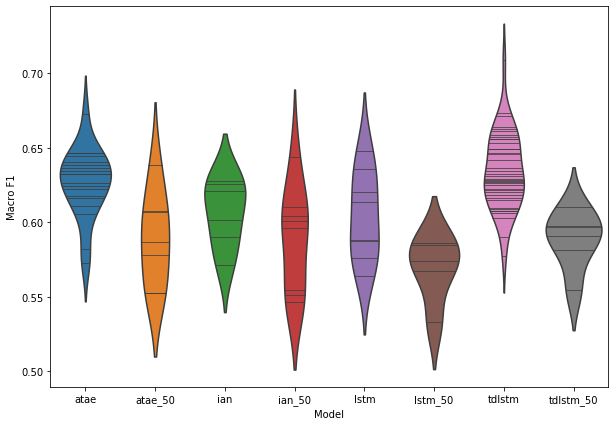

In [44]:
fc_df_data = defaultdict(list)
for model_name, eval_scores in zip(model_names, fc_model_evaluation_scores):
  for eval_score in eval_scores:
    fc_df_data['Model'].append(model_name)
    fc_df_data['Macro F1'].append(eval_score)
df_data = pd.DataFrame(fc_df_data)
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.violinplot(x="Model", y="Macro F1", data=fc_df_data ,inner="stick")
ax.set_xlabel('Model')
ax.set_ylabel('Macro F1')

## Fixed Budget (FB)

In this case we want to find the best model form a set of models $N$ given a budget of $T$ model evaluations/runs. Unlike the FC methods we cannot guarantee a confidence on the best model being the best model.

To do this we have two option within the FIESTA package for FB:
1. [`fiesta.sequential_halving`](https://apmoore1.github.io/fiesta/api/fiesta.sequential_halving.html) - This is the adaptive method which breaks the problem down into several rounds where at each round each model is evaluated a set number of times based on budget, number of models in the round, and the total number of models. After each round the worse performing models are dropped. The best model is the model that gets to the last round. At each round the models are evaluated more often thus the better models should be evaluated more.
2. [`fiesta.non_adaptive_fb`](https://apmoore1.github.io/fiesta/api/fiesta.sequential_halving.html) - This is the more "standard" approach which is non-adaptive as each round it evaluates each model $\lfloor T/N \rfloor$ times. After which the best model is the model with the highest mean score. Compared to Sequential Halving this treats each model fairly therefore does not evaluate more promising/better models more.

For more details about these methods read the [FIESTA paper](https://arxiv.org/pdf/1906.12230.pdf) or for a shorter description the functions documentation.

As it has been shown in the [FIESTA paper](https://arxiv.org/pdf/1906.12230.pdf) the Sequential Halving approach is better as it is more likely to choose the best model given the budget constriant. 

In the code block below we give the `sequential_halving` function: 
1. The whole dataset
2 .The model functions
3. How to split the data. 
4. The budget

In this case the budget is 32.

In [23]:
%%timeit -n 1 -r 1
%%capture
fb_results = fiesta.sequential_halving(whole_dataset, all_model_functions,
                                       split_data, budget=32)
best_model_index = fb_results[0]
fb_number_times_each_model_evaluated = fb_results[1]
fb_model_evaluation_scores = fb_results[2]

15min 33s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [46]:
# Needed for the notebook to release CUDA memory
torch.cuda.empty_cache()

print(f'Best model: {model_names[best_model_index]}')

Best model: tdlstm


Sequential Halving found the best model to be TDLSTM with 300 dimension embedding which as we know from the [FIESTA paper ](https://arxiv.org/pdf/1906.12230.pdf) is the best model.

Further more we can see the proportion of the evaluations that were given to each model:

In [51]:
name_proportion = sorted(zip(model_names, fb_number_times_each_model_evaluated),
                             key=lambda x: x[1], reverse=True)
for model_name, eval_proportion in name_proportion:
  print(f'Model: {model_name}, proportion of evaluations: {eval_proportion}')

Model: ian, proportion of evaluations: 0.3076923076923077
Model: tdlstm, proportion of evaluations: 0.3076923076923077
Model: ian_50, proportion of evaluations: 0.11538461538461539
Model: tdlstm_50, proportion of evaluations: 0.11538461538461539
Model: atae, proportion of evaluations: 0.038461538461538464
Model: atae_50, proportion of evaluations: 0.038461538461538464
Model: lstm, proportion of evaluations: 0.038461538461538464
Model: lstm_50, proportion of evaluations: 0.038461538461538464


As we can see the last two models where IAN and TDLSTM.

Lastly like the FC methods we can get each models evaluation scores from each run/evaluation:

Text(0, 0.5, 'Macro F1')

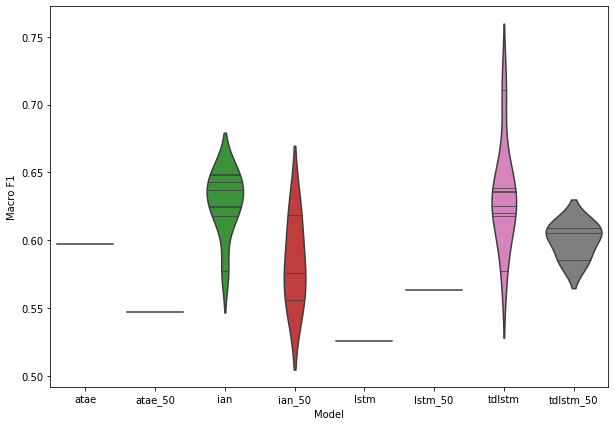

In [52]:
fb_df_data = defaultdict(list)
for model_name, eval_scores in zip(model_names, fb_model_evaluation_scores):
  for eval_score in eval_scores:
    fb_df_data['Model'].append(model_name)
    fb_df_data['Macro F1'].append(eval_score)
fb_df_data = pd.DataFrame(fb_df_data)
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.violinplot(x="Model", y="Macro F1", data=fb_df_data ,inner="stick")
ax.set_xlabel('Model')
ax.set_ylabel('Macro F1')